In [1]:
import geopandas as gpd
import os
from pprint import pprint
import numpy as np
from matplotlib import pyplot as plt
import rasterio as rio

# Import helper modules
import json
import mercantile
import requests
import urllib

from pl_b2p import *
from b2p_helpers import get_aoi_merc_tiles

In [6]:
# load the shapefile
rwanda_aoi = gpd.read_file('../../Fwd__B2P_and_Earth_Lab_areas_of_interest/rwanda_aoi_big.geojson')
rwanda_aoi.head()

uganda_pts = '../../training-data/uganda_no_pts1.geojson'
uganda_aoi = gpd.read_file(uganda_pts)

# remove null island points
uganda_aoi = uganda_aoi.loc[np.abs(uganda_aoi.geometry.x) > 1]

# generate polygons for points
uganda_aoi_poly = uganda_aoi.copy()
uganda_aoi_poly = uganda_aoi_poly.to_crs(epsg=3857)
uganda_aoi_poly['geometry'] = [g.buffer(1) for g in uganda_aoi_poly.geometry]
uganda_aoi_poly = uganda_aoi_poly.to_crs(epsg=4326)

#aoi_bounds = rwanda_aoi.unary_union.bounds
aoi_bounds = uganda_aoi_poly.unary_union.bounds

In [3]:
aoi = gpd.read_file(r"C:\Users\jomc9287\Downloads\wb_boundaries_geojson_lowres\WB_countries_Admin0_lowres.geojson")

In [9]:
uganda_aoi_poly = aoi[aoi.FORMAL_EN == 'Republic of Uganda']
aoi_bounds = uganda_aoi_poly.unary_union.bounds

In [13]:
pts15, polys15 = get_aoi_merc_tiles(aoi_bounds, tsize=15)
polys15 = polys15[polys15.intersects(uganda_aoi_poly.unary_union)]

pts16, polys16 = get_aoi_merc_tiles(aoi_bounds, tsize=16)
polys16 = polys16[polys16.intersects(uganda_aoi_poly.unary_union)]


In [14]:
polys15.shape

(41277, 1)

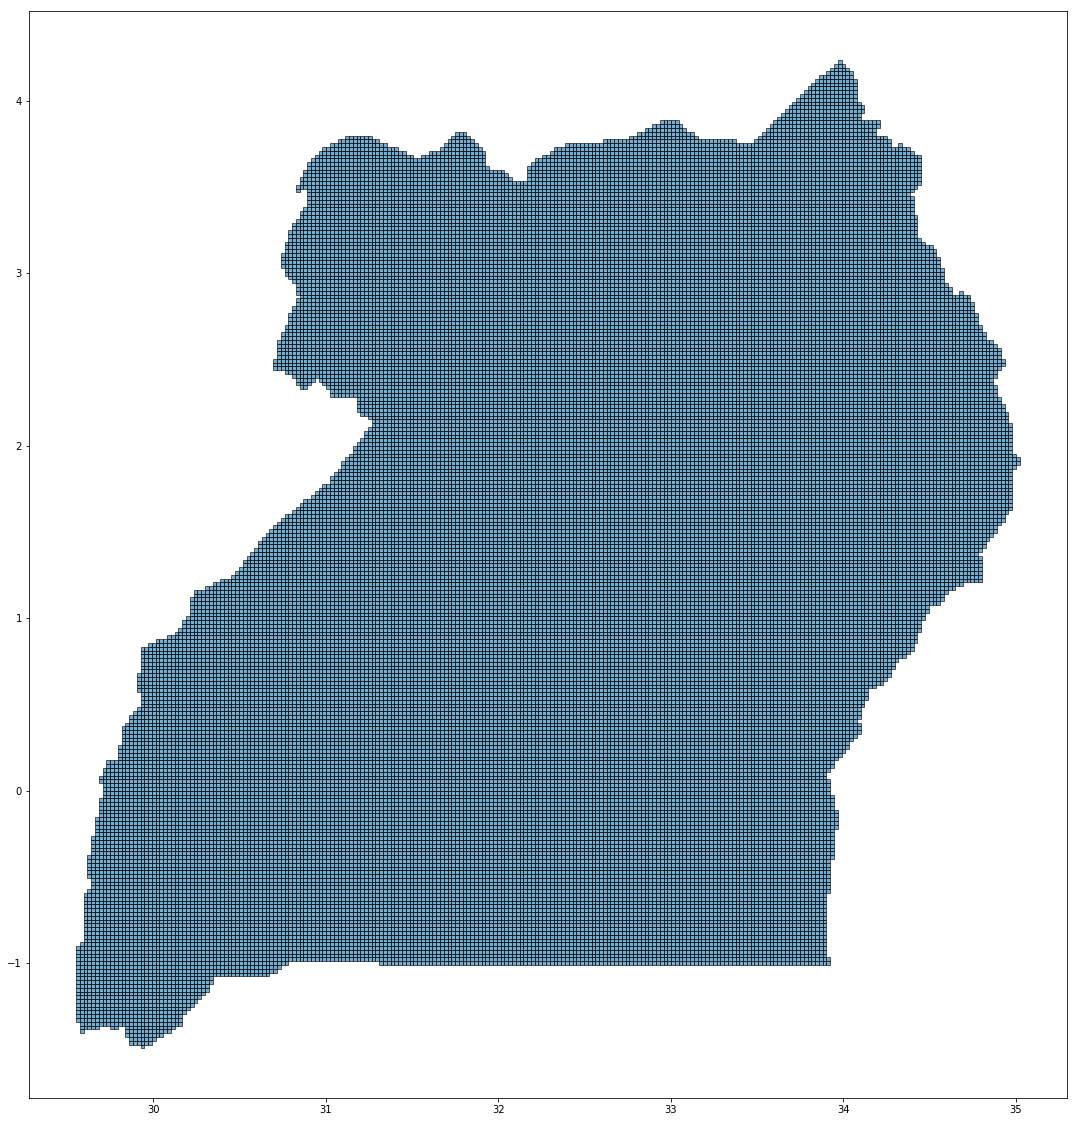

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
polys15.plot(alpha=0.6, edgecolor='k', ax=ax)

In [25]:
x_ls = []
y_ls = []
z_ls = []
f_ls = []
url_ls = []
aoi_folder = '.'
aoi_name = 'uganda_no'

for row in polys16.iterrows():
    # specify a point from the geodataframe of accepted stages
    # get a tile coordiante for lon lat  (get from GDF)
    #pt_index=50
    #lon = rwanda_pts_NR.geometry[pt_index].x
    #lat = rwanda_pts_NR.geometry[pt_index].y
    
    try:
        rc = 512

        lon = row[1]['geometry'].centroid.x
        lat = row[1]['geometry'].centroid.y
        zm = 16 # ~1.2m

        t_url = f'https://dev.virtualearth.net/REST/v1/Imagery/Map/Aerial/{lat},{lon}/{zm}?&format=png&mapSize={rc},{rc}&key=AkmwMAxGMq8p9opIZzGMenqb5Ekz6D5-RAHs_J-vg5fqhsnUm4bhdmDYlk7M3vBx'
        
        tile_mapping = mercantile.tile(lon, lat, zm)

        z=tile_mapping.z
        x=tile_mapping.x
        y=tile_mapping.y
        im_path = os.path.join(aoi_folder, f'aoi_{aoi_name}_bing_{x}_{y}_{z}.png')
        #urllib.request.urlretrieve(t_url, im_path)

        x_ls.append(x)
        y_ls.append(y)
        z_ls.append(z)
        f_ls.append(im_path)
        url_ls.append(t_url)
        
    except Exception as e:
        print(e)
        x_ls.append(None)
        y_ls.append(None)
        z_ls.append(None)
        f_ls.append(None)

In [26]:
import pandas as pd 

df_dict = {'x_tile': x_ls,
          'y_tile': y_ls,
          'z_tile': z_ls,
          'filename': f_ls,
          'url': url_ls}
temp_df = pd.DataFrame(df_dict)

In [34]:
# find some samples, like 38900_32901
#temp_df.loc['38900_32901' in temp_df['url']]
[u for i,u in zip(temp_df['filename'], temp_df['url']) if '38887_32912_16' in i]
# [i for i in temp_df['filename'] if '38887_' in i]

['https://dev.virtualearth.net/REST/v1/Imagery/Map/Aerial/-0.7964831314538381,33.6126708984375/16?&format=png&mapSize=512,512&key=AkmwMAxGMq8p9opIZzGMenqb5Ekz6D5-RAHs_J-vg5fqhsnUm4bhdmDYlk7M3vBx']

In [28]:
temp_df['filename']

0      .\aoi_uganda_no_bing_38329_32511_16.png
1      .\aoi_uganda_no_bing_38333_32507_16.png
2      .\aoi_uganda_no_bing_38333_32521_16.png
3      .\aoi_uganda_no_bing_38335_32547_16.png
4      .\aoi_uganda_no_bing_38343_32485_16.png
5      .\aoi_uganda_no_bing_38345_32535_16.png
6      .\aoi_uganda_no_bing_38347_32475_16.png
7      .\aoi_uganda_no_bing_38347_32507_16.png
8      .\aoi_uganda_no_bing_38351_32495_16.png
9      .\aoi_uganda_no_bing_38351_32501_16.png
10     .\aoi_uganda_no_bing_38351_32525_16.png
11     .\aoi_uganda_no_bing_38351_32537_16.png
12     .\aoi_uganda_no_bing_38353_32545_16.png
13     .\aoi_uganda_no_bing_38355_32471_16.png
14     .\aoi_uganda_no_bing_38355_32479_16.png
15     .\aoi_uganda_no_bing_38355_32535_16.png
16     .\aoi_uganda_no_bing_38357_32469_16.png
17     .\aoi_uganda_no_bing_38357_32493_16.png
18     .\aoi_uganda_no_bing_38361_32503_16.png
19     .\aoi_uganda_no_bing_38363_32459_16.png
20     .\aoi_uganda_no_bing_38363_32495_16.png
21     .\aoi_

In [ ]:
polys17.to_file('../../training-data/rw_polys_zm17.geojson')
polys16.to_file('../../training-data/rw_polys_zm16.geojson')